In [25]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [26]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

In [27]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

dataset = pd.read_csv(url, names=column_names, na_values='?',
                      comment='\t', sep=' ', skipinitialspace=True)

In [28]:
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [29]:
# clean data
dataset = dataset.dropna()

# convert categorical 'Origin' data into one-hot data
origin = dataset.pop('Origin')
dataset['USA'] = (origin == 1)*1
dataset['Europe'] = (origin == 2)*1
dataset['Japan'] = (origin == 3)*1

In [30]:
# Split the data into train and test
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

print(dataset.shape, train_dataset.shape, test_dataset.shape)
train_dataset.describe().transpose()

(392, 10) (314, 10) (78, 10)


,count,mean,std,min,25%,50%,75%,max
MPG,314.0,23.310510,7.728652,10.0,17.00,22.0,28.95,46.6
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0


In [31]:
# split features from labels
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('MPG')
test_labels = test_features.pop('MPG')

In [32]:
def plot(features,x=None,y=None):
    plt.figure(figsize=(10,8))
    plt.scatter(train_features[features],
train_labels,label='Data')
    if x is not None and y is not None:
        plt.plot(x,y,color ='k',label="Prediction")
    plt.xlabel(features)
    plt.ylabel("MPG")
    plt.legend()
    plt.show()

In [33]:
print(train_dataset.describe().transpose()[['mean', 'std']])

# Normalization
normalizer = preprocessing.Normalization()

# adapt to the data
normalizer.adapt(np.array(train_features))
print(normalizer.mean.numpy())


                     mean         std
MPG             23.310510    7.728652
Cylinders        5.477707    1.699788
Displacement   195.318471  104.331589
Horsepower     104.869427   38.096214
Weight        2990.251592  843.898596
Acceleration    15.559236    2.789230
Model Year      75.898089    3.675642
USA              0.624204    0.485101
Europe           0.178344    0.383413
Japan            0.197452    0.398712
[5.47770691e+00 1.95318497e+02 1.04869446e+02 2.99025171e+03
 1.55592356e+01 7.58980942e+01 6.24203861e-01 1.78343967e-01
 1.97452217e-01]


In [34]:
first = np.array(train_features[:1])
print('First example:', first)
print('Normalized:', normalizer(first).numpy())

First example: [[4.000e+00 9.000e+01 7.500e+01 2.125e+03 1.450e+01 7.400e+01 1.000e+00
  0.000e+00 0.000e+00]]
Normalized: [[-0.8707355  -1.0110706  -0.7853045  -1.0269395  -0.38036528 -0.51722217
   0.7759129  -0.46589085 -0.49601588]]


In [38]:
feature = "Horsepower"
single_feature = np.array(train_features[feature])
print(single_feature.shape,train_features.shape)
# Normalization
single_feature_normalizer = preprocessing.Normalization()

# adapt to the data
single_feature_normalizer.adapt(single_feature)

(314,) (314, 9)


In [40]:
single_feature_model = keras.models.Sequential([
    single_feature_normalizer,
    layers.Dense(units=1)
])

In [41]:
single_feature_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_4 (Normalizati (None, 1)                 3         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 2         
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


In [45]:
loss = keras.losses.MeanAbsoluteError()
optim = keras.optimizers.Adam(lr=0.2)
single_feature_model.compile(optimizer = optim,loss= loss)

In [46]:
history = single_feature_model.fit(
    train_features[feature], train_labels,
    epochs=100,
    verbose=1,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2)

Epoch 1/100
8/8 [==============================] - 1s 44ms/step - loss: 22.5256 - val_loss: 22.1334
Epoch 2/100
8/8 [==============================] - 0s 8ms/step - loss: 20.9190 - val_loss: 20.5334
Epoch 3/100
8/8 [==============================] - 0s 6ms/step - loss: 19.3239 - val_loss: 18.9338
Epoch 4/100
8/8 [==============================] - 0s 7ms/step - loss: 17.7197 - val_loss: 17.3336
Epoch 5/100
8/8 [==============================] - 0s 7ms/step - loss: 16.1192 - val_loss: 15.7336
Epoch 6/100
8/8 [==============================] - 0s 7ms/step - loss: 14.5238 - val_loss: 14.1332
Epoch 7/100
8/8 [==============================] - 0s 6ms/step - loss: 12.9211 - val_loss: 12.5335
Epoch 8/100
8/8 [==============================] - 0s 6ms/step - loss: 11.3238 - val_loss: 10.9636
Epoch 9/100
8/8 [==============================] - 0s 6ms/step - loss: 9.7926 - val_loss: 9.4340
Epoch 10/100
8/8 [==============================] - 0s 6ms/step - loss: 8.3212 - val_loss: 7.9173
Epoch 11/100

8/8 [==============================] - 0s 7ms/step - loss: 3.8066 - val_loss: 4.1877
Epoch 85/100
8/8 [==============================] - 0s 7ms/step - loss: 3.8042 - val_loss: 4.2086
Epoch 86/100
8/8 [==============================] - 0s 6ms/step - loss: 3.8050 - val_loss: 4.2004
Epoch 87/100
8/8 [==============================] - 0s 6ms/step - loss: 3.8062 - val_loss: 4.2018
Epoch 88/100
8/8 [==============================] - 0s 6ms/step - loss: 3.8055 - val_loss: 4.1512
Epoch 89/100
8/8 [==============================] - 0s 6ms/step - loss: 3.8064 - val_loss: 4.1518
Epoch 90/100
8/8 [==============================] - 0s 7ms/step - loss: 3.8130 - val_loss: 4.2094
Epoch 91/100
8/8 [==============================] - 0s 7ms/step - loss: 3.8087 - val_loss: 4.2047
Epoch 92/100
8/8 [==============================] - 0s 6ms/step - loss: 3.8085 - val_loss: 4.1773
Epoch 93/100
8/8 [==============================] - 0s 6ms/step - loss: 3.8116 - val_loss: 4.1385
Epoch 94/100
8/8 [===============

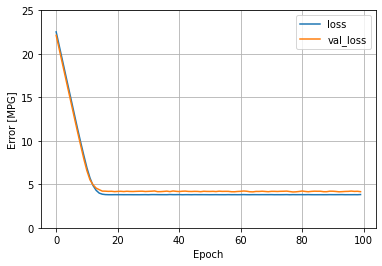

In [47]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0, 25])
    plt.xlabel('Epoch')
    plt.ylabel('Error [MPG]')
    plt.legend()
    plt.grid(True)
plot_loss(history)

In [49]:
single_feature_model.evaluate(
    test_features[feature],
    test_labels, verbose=1)

3/3 [==============================] - 0s 0s/step - loss: 3.6775


3.6775104999542236

#Creating a predict

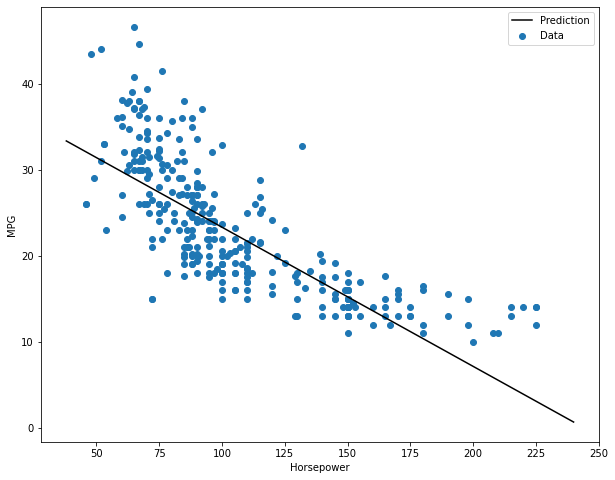

In [56]:
range_min = np.min(test_features[feature]) - 10
range_max = np.max(test_features[feature]) + 10
x = tf.linspace(range_min, range_max, 200)
y = single_feature_model.predict(x)
plot(feature, x,y)

In [57]:
dnn_model = keras.models.Sequential([
     single_feature_normalizer,
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
])

In [58]:

dnn_model.compile(loss=loss, 
                  optimizer=tf.keras.optimizers.Adam(0.001))

dnn_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_4 (Normalizati (None, 1)                 3         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                128       
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 4,356
Trainable params: 4,353
Non-trainable params: 3
_________________________________________________________________


In [59]:
dnn_model.fit(
    train_features[feature], train_labels,
    epochs=100,
    verbose=1,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2)

Epoch 1/100
8/8 [==============================] - 1s 54ms/step - loss: 23.1769 - val_loss: 23.5604
Epoch 2/100
8/8 [==============================] - 0s 9ms/step - loss: 22.9356 - val_loss: 23.2940
Epoch 3/100
8/8 [==============================] - 0s 9ms/step - loss: 22.6768 - val_loss: 22.9979
Epoch 4/100
8/8 [==============================] - 0s 8ms/step - loss: 22.3743 - val_loss: 22.6460
Epoch 5/100
8/8 [==============================] - 0s 8ms/step - loss: 22.0033 - val_loss: 22.1896
Epoch 6/100
8/8 [==============================] - 0s 9ms/step - loss: 21.5129 - val_loss: 21.5929
Epoch 7/100
8/8 [==============================] - 0s 9ms/step - loss: 20.8669 - val_loss: 20.8097
Epoch 8/100
8/8 [==============================] - 0s 10ms/step - loss: 20.0261 - val_loss: 19.7847
Epoch 9/100
8/8 [==============================] - 0s 11ms/step - loss: 18.9347 - val_loss: 18.5219
Epoch 10/100
8/8 [==============================] - 0s 9ms/step - loss: 17.6407 - val_loss: 17.0790
Epoch 

8/8 [==============================] - 0s 10ms/step - loss: 3.2595 - val_loss: 3.7747
Epoch 85/100
8/8 [==============================] - 0s 12ms/step - loss: 3.2599 - val_loss: 3.7788
Epoch 86/100
8/8 [==============================] - 0s 12ms/step - loss: 3.2654 - val_loss: 3.7694
Epoch 87/100
8/8 [==============================] - 0s 11ms/step - loss: 3.2670 - val_loss: 3.7536
Epoch 88/100
8/8 [==============================] - 0s 9ms/step - loss: 3.2583 - val_loss: 3.7643
Epoch 89/100
8/8 [==============================] - 0s 7ms/step - loss: 3.2584 - val_loss: 3.7706
Epoch 90/100
8/8 [==============================] - 0s 8ms/step - loss: 3.2549 - val_loss: 3.7620
Epoch 91/100
8/8 [==============================] - 0s 9ms/step - loss: 3.2524 - val_loss: 3.7600
Epoch 92/100
8/8 [==============================] - 0s 9ms/step - loss: 3.2553 - val_loss: 3.7739
Epoch 93/100
8/8 [==============================] - 0s 10ms/step - loss: 3.2538 - val_loss: 3.7606
Epoch 94/100
8/8 [==========

In [60]:
dnn_model.evaluate(
    test_features[feature],
    test_labels, verbose=1)

3/3 [==============================] - 0s 4ms/step - loss: 2.8715


2.87145733833313

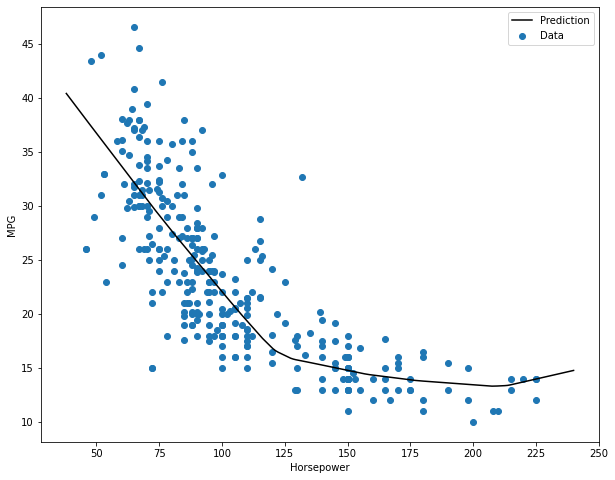

In [61]:
x = tf.linspace(range_min, range_max, 200)
y = dnn_model.predict(x)

plot(feature, x,y)

In [62]:
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

linear_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss=loss)

In [63]:

linear_model.fit(
    train_features, train_labels, 
    epochs=100,
    verbose=1,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2)

Epoch 1/100
8/8 [==============================] - 1s 49ms/step - loss: 22.9167 - val_loss: 22.9741
Epoch 2/100
8/8 [==============================] - 0s 9ms/step - loss: 22.0871 - val_loss: 22.2839
Epoch 3/100
8/8 [==============================] - 0s 10ms/step - loss: 21.2330 - val_loss: 21.5527
Epoch 4/100
8/8 [==============================] - 0s 9ms/step - loss: 20.4092 - val_loss: 20.8429
Epoch 5/100
8/8 [==============================] - 0s 9ms/step - loss: 19.6015 - val_loss: 20.1211
Epoch 6/100
8/8 [==============================] - 0s 9ms/step - loss: 18.7748 - val_loss: 19.4111
Epoch 7/100
8/8 [==============================] - 0s 9ms/step - loss: 17.9480 - val_loss: 18.6719
Epoch 8/100
8/8 [==============================] - 0s 10ms/step - loss: 17.1362 - val_loss: 17.9451
Epoch 9/100
8/8 [==============================] - 0s 9ms/step - loss: 16.3317 - val_loss: 17.2538
Epoch 10/100
8/8 [==============================] - 0s 8ms/step - loss: 15.5371 - val_loss: 16.4804
Epoch 

Epoch 84/100
8/8 [==============================] - 0s 8ms/step - loss: 2.4745 - val_loss: 2.4622
Epoch 85/100
8/8 [==============================] - 0s 9ms/step - loss: 2.4833 - val_loss: 2.5208
Epoch 86/100
8/8 [==============================] - 0s 8ms/step - loss: 2.4676 - val_loss: 2.4599
Epoch 87/100
8/8 [==============================] - 0s 7ms/step - loss: 2.4837 - val_loss: 2.4656
Epoch 88/100
8/8 [==============================] - 0s 7ms/step - loss: 2.4715 - val_loss: 2.4966
Epoch 89/100
8/8 [==============================] - 0s 8ms/step - loss: 2.4898 - val_loss: 2.4683
Epoch 90/100
8/8 [==============================] - 0s 7ms/step - loss: 2.4827 - val_loss: 2.5023
Epoch 91/100
8/8 [==============================] - 0s 8ms/step - loss: 2.4941 - val_loss: 2.4566
Epoch 92/100
8/8 [==============================] - 0s 8ms/step - loss: 2.5169 - val_loss: 2.4701
Epoch 93/100
8/8 [==============================] - 0s 9ms/step - loss: 2.4817 - val_loss: 2.4914
Epoch 94/100
8/8 [==

In [64]:
linear_model.evaluate(
    test_features, test_labels, verbose=1)

3/3 [==============================] - 0s 5ms/step - loss: 2.4967


2.4967129230499268

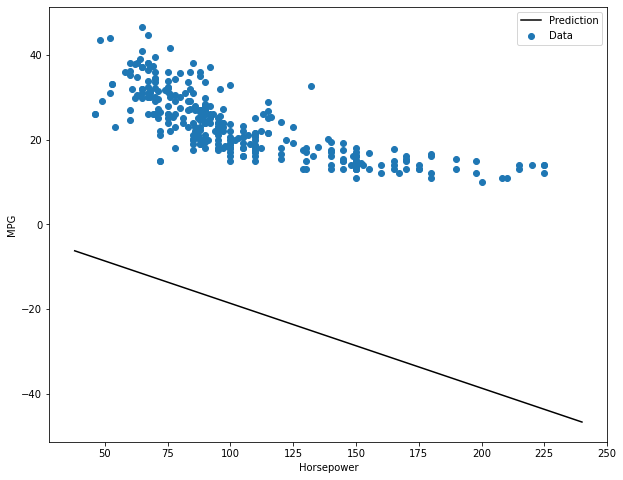

In [66]:
x = tf.linspace(range_min, range_max, 5)
y = linear_model.predict(x)

plot(feature, x,y)